## https://www.datahubbs.com/reinforce-with-pytorch/
## http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture14.pdf
## https://github.com/vitchyr/rlkit

In [30]:
import numpy as np 
#import matplotlib.pyplot as plt
from scipy.stats import norm
from math import *
from utility import *
import matplotlib.pyplot as plt

In [31]:
class BS_env:
    def __init__(self, S0,K,r,mu,sigma,T,nsim):
        self.S0 = S0
        self.K = K
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.nsim = nsim
        self.dt = T/np.float(nsim)
        self.S = S0 #current stock
        self.t = 0 #current
        #self.B = 0 #brownian
        self.share = 0 #current share
        self.R = 0
        self.opt_price = self.bs_call()['callprice']
        self.bank = self.opt_price/(1+self.r) #only trick
        self.cost = 0

    def bs_call(self):
        S = self.S
        X = self.K
        T = self.T - self.t
        sigma =  self.sigma
        r = self.r
        d1 = (log(S/X)+(r+sigma*sigma/2.0)*T)/np.float(sigma*sqrt(T))   
        d2 = d1-sigma*sqrt(T)
        callprice = S*norm.cdf(d1)-X*exp(-r*T)*norm.cdf(d2)     #Calculate the Call price
        delta = norm.cdf(d1)                                    #Calculate the delta value
        return {'delta':delta, 'callprice':callprice}
    def reset(self):
        self.S = S0 #current stock
        self.t = 0 #current
        #self.B = 0 #brownian
        self.share = 0 #current share
        self.R = 0
        self.opt_price = self.bs_call()['callprice']
        self.bank = self.opt_price/(1+self.r) #only trick
        self.cost = 0
        return np.array([self.S,self.t])
    def step(self,action):
        self.cost = (action)*self.S 
        self.bank = self.bank*(1+self.r) - (action - self.share)*self.S
        self.share = action
        self.t = self.dt + self.t
        
        self.R = -np.abs(self.bank + self.cost  - self.opt_price)
        
        self.S =self.S + self.S * self.mu * self.dt + self.S * self.sigma * np.sqrt(self.dt)*np.random.normal()


        self.opt_price = self.bs_call()['callprice']
        if (self.t == self.T): 
            done =1
        else:
            done=0
        return np.array([self.S,self.t]), self.R, done

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable
from torch.distributions.distribution import Distribution



In [33]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(Actor, self).__init__()
        self.num_outputs = num_outputs
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
 
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        #value = self.critic(x)
        probs = self.actor(x)
        #dist  = Categorical(probs)
        return probs
    
    def action(self, x):
        #value = self.critic(x)
        probs = self.actor(x)
        m = Categorical(probs)
        action = m.sample()
        log_probs = m.log_prob(action)
        return action.to(dtype=torch.float)/self.num_outputs, log_probs
        #z = probs.multinomial(1, replacement=True)
        #log_probs = Multinomial(probs= probs).log_prob(z)
        #return z.numpy()/self.num_outputs, log_probs

class Critic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(Critic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
 
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            #nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        #probs = self.actor(x)
        #dist  = Categorical(probs)
        return value

In [34]:
num_inputs =2 #gia va time
num_action =10
num_val = 1
hidden_size = 10


ac = Actor(num_inputs, num_action, hidden_size)  
cri = Critic(num_inputs, num_val, hidden_size)  

optimizer_ac = torch.optim.SGD(ac.parameters(),lr=0.00001)
optimizer_cri = torch.optim.SGD(cri.parameters(),lr=0.00001)

loss_fn = torch.nn.MSELoss()




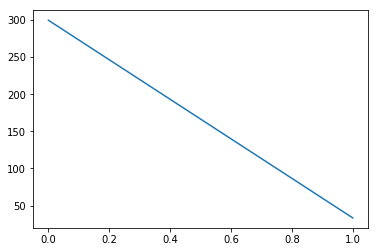

In [42]:
# Superparameters
OUTPUT_GRAPH = 1
MAX_EPISODE = 2
DISPLAY_REWARD_THRESHOLD = 200  # renders environment if total episode reward is greater then this threshold
MAX_EP_STEPS = 1000   # maximum time step in one episode
RENDER = False  # rendering wastes time
GAMMA = 0.9     # reward discount in TD error
LR_A = 0.001    # learning rate for actor
LR_C = 0.01     # learning rate for critic

### BS parameters
S0 = 100
K = 100
r = 0.01/(1000/T)
mu = 0.1
sigma = 0.2
T = 1
nsim =100


ENV1 = BS_env(S0,K,r,mu,sigma,T,nsim)
l_tam = []
for i in range(MAX_EPISODE):
    s = ENV1.reset()
    states = []
    next_states = []
    rewards = []
    actions = []
    log_probs = []
    #complete = False
    critic_target = []
    for i in range(nsim-1):
        aaaa,lo = ac.action(torch.Tensor([[s]]))
        action = np.reshape(aaaa,1)
        #action = ENV1.bs_call()['delta']
        log_prob = lo.detach().numpy().item()
        s1, R, complete = ENV1.step(action)
        #print(action)
        
        states.append(s)
        next_states.append(s1)
        s = s1
        rewards.append(R.item())
        actions.append(action.item())
        log_probs.append(log_prob)
    SS = np.expand_dims(states, axis=1)
    Snext = np.expand_dims(next_states, axis=1)
    RR = np.expand_dims(rewards, axis=1)
    Llog_probs = np.expand_dims(log_probs, axis=1)
    #critic_target = RR+ GAMMA* cri(torch.Tensor(SS)).detach().numpy()
    critic_target = torch.Tensor(RR)+ GAMMA* cri(torch.Tensor(Snext))

    critic_loss = F.smooth_l1_loss(critic_target,cri(torch.Tensor(SS)))
    tdd = critic_target - cri(torch.Tensor(SS))
    td = Variable(tdd, requires_grad = False).float() 
    
    log_p = Variable(torch.tensor(Llog_probs), requires_grad = True).float() 
    actor_loss = (log_p*td).sum()
    
    #
    l_tam.append((np.asarray(rewards)**2).mean())
    #
    optimizer_cri.zero_grad
    critic_loss.backward()
    optimizer_cri.step()
    #l_tam.append(loss.data.numpy())
    optimizer_ac.zero_grad
    actor_loss.backward()
    optimizer_ac.step()
    
    
plt.plot(np.asarray(l_tam))